## Week 1: Data Science

### 1. Data Collation and Pre-processing

#### Collating the files so that all the information is in one place.

In [2]:
import pandas as pd
hospitalization_df = pd.read_excel('Hospitalisation details.xlsx')
medical_examinations_df = pd.read_excel('Medical Examinations.xlsx')
names_df = pd.read_excel('Names.xlsx')

In [3]:
merged_df = pd.merge(hospitalization_df, medical_examinations_df, on='Customer ID', how='inner')

In [4]:
final_df = pd.merge(merged_df, names_df, on='Customer ID', how='inner')

#### Checking for missing values in the dataset.

In [5]:
missing_values = final_df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


#### Finding the percentage of rows that have trivial value (for example, ?), and delete such rows if they do not contain significant information. 

In [6]:
import numpy as np
# Example: Replacing '?' with NaN across the DataFrame
final_df.replace('?', np.nan, inplace=True)
# Recalculate missing values after replacement
missing_values_after_replacement = final_df.isnull().sum()
print(missing_values_after_replacement[missing_values_after_replacement > 0])
# Determining a threshold for dropping rows (e.g., if a row has more than X% missing/trivial values)
# For simplicity, if a column has many '?' values that are now NaN, we might drop rows with NaN in critical columns or impute.
# If a row has '?' that makes it non-significant, we'd specify which columns
# For instance, if 'charges' has '?', drop those rows:
final_df.dropna(subset=['charges'], inplace=True) # Example for a critical column

year             2
month            3
Hospital tier    1
City tier        1
State ID         2
smoker           2
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_2636\2454685375.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df.replace('?', np.nan, inplace=True)


#### Using the necessary transformation methods to deal with the nominal and ordinal categorical variables in the dataset. 

In [7]:
# Manual mapping for ordinal variables if there's a clear order
hospital_tier_mapping = {'tier-1': 3, 'tier-2': 2, 'tier-3': 1}
city_tier_mapping = {'tier-1': 3, 'tier-2': 2, 'tier-3': 1}
final_df['Hospital tier'] = final_df['Hospital tier'].map(hospital_tier_mapping)
final_df['City tier'] = final_df['City tier'].map(city_tier_mapping)

In [8]:
# For binary nominal variables, map to 0/1
binary_map = {'Yes': 1, 'No': 0}
for col in ['Heart Issues', 'Any Transplants', 'Cancer history', 'smoker']:
    final_df[col] = final_df[col].map(binary_map)

#### The dataset has State ID, which has around 16 states. All states are not represented in equal proportions in the data. Creating dummy variables for all regions may also result in too many insignificant predictors. Nevertheless, only R1011, R1012, and R1013 are worth investigating further. Hence designing a suitable strategy to create dummy variables with these constraints.

In [9]:
important_states = ['R1011', 'R1012', 'R1013']
final_df['State_R1011'] = (final_df['State ID'] == 'R1011').astype(int)
final_df['State_R1012'] = (final_df['State ID'] == 'R1012').astype(int)
final_df['State_R1013'] = (final_df['State ID'] == 'R1013').astype(int)
# We might choose to drop the original 'State ID' column if not needed further
# final_df.drop('State ID', axis=1, inplace=True)

#### The variable NumberOfMajorSurgeries also appears to have string values. Hence Applying a suitable method to clean up this variable.

In [10]:
# Example mapping based on potential values
# Assuming 'More than 2' maps to 3 for numerical representation
# We might need to handle cases like 'zero' as 0
def clean_surgeries(val):
    if isinstance(val, str):
        val = val.lower().strip()
        if val == 'zero': return 0
        elif val == 'one': return 1
        elif val == 'two': return 2
        elif val == 'more than 2': return 3 # Or will handle as a separate category if needed
        else: return np.nan # Or other strategy for unknown strings
    return val # Return as is if already a number or NaN

final_df['NumberOfMajorSurgeries'] = final_df['NumberOfMajorSurgeries'].apply(clean_surgeries)
# Converting to numeric type, coercing errors will turn unconvertible values into NaN
final_df['NumberOfMajorSurgeries'] = pd.to_numeric(final_df['NumberOfMajorSurgeries'], errors='coerce')

### 2. Feature Engineering (Continued)

In [11]:
import pandas as pd
from datetime import datetime
import numpy as np

required_date_cols = ['year', 'month', 'date']
for col in required_date_cols:
    if col not in final_df.columns:
        print(f"Error: Required column '{col}' is missing from final_df.")
        raise KeyError(f"Column '{col}' not found. Please check dataset merging.")

print("Before date component cleaning and type conversion:")
print(final_df[required_date_cols].info())
print(final_df[required_date_cols].isnull().sum())
print("-" * 30)

for col in required_date_cols:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

    if col == 'year':
        if final_df[col].isnull().all():
            final_df[col] = 2000 # Default if entire column is NaN
        else:
            final_df[col] = final_df[col].fillna(final_df[col].median()).astype(int)
    elif col in ['month', 'date']:
        final_df[col] = final_df[col].fillna(1).astype(int)

print("After date component cleaning and type conversion:")
print(final_df[required_date_cols].info())
print(final_df[required_date_cols].isnull().sum()) # This should show 0 for these columns
print("-" * 30)


final_df['DOB'] = pd.to_datetime(final_df[['year', 'month', 'date']].astype(str).agg('-'.join, axis=1), errors='coerce')


initial_rows_dob = final_df.shape[0]
final_df.dropna(subset=['DOB'], inplace=True)
rows_after_dob_drop = final_df.shape[0]
if initial_rows_dob - rows_after_dob_drop > 0:
    print(f"Dropped {initial_rows_dob - rows_after_dob_drop} rows where DOB could not be determined (NaT values).")

current_year = 2025
final_df['Age'] = current_year - final_df['DOB'].dt.year

final_df.drop(['year', 'month', 'date', 'DOB'], axis=1, inplace=True)

print("Age calculation complete and date columns dropped.")
print(final_df[['Age']].head())

Before date component cleaning and type conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    2333 non-null   float64
 1   month   2332 non-null   object 
 2   date    2335 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 54.9+ KB
None
year     2
month    3
date     0
dtype: int64
------------------------------
After date component cleaning and type conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    2335 non-null   int32
 1   month   2335 non-null   int32
 2   date    2335 non-null   int32
dtypes: int32(3)
memory usage: 27.5 KB
None
year     0
month    0
date     0
dtype: int64
------------------------------
Age calculation complete and date columns dropped.
   Age
0

#### The gender of the patient may be an important factor in determining the cost of hospitalization. The salutations in a beneficiary's name can be used to determine their gender. Thus making a new field for the beneficiary's gender.

In [12]:
def get_gender(name):
    name = str(name).lower()
    if 'mr.' in name:
        return 'Male'
    elif 'ms.' in name or 'mrs.' in name or 'miss.' in name:
        return 'Female'
    elif 'dr.' in name: # Doctors can be male or female, might need more context or mark as 'Unknown'
        return 'Unknown'
    else:
        return 'Unknown' 
final_df['Gender'] = final_df['name'].apply(get_gender)
# Converting Gender to numerical/dummy variable as needed for modeling
final_df = pd.get_dummies(final_df, columns=['Gender'], drop_first=True) # Creates 'Gender_Male', 'Gender_Unknown'
# Dropping original name column
final_df.drop('name', axis=1, inplace=True)

### 3. Data Visualization

#### Will Visualize the distribution of costs using a histogram, box and whisker plot, and swarm plot. Stating how the distribution is different across gender and tiers of hospitals.


--- Plotting Cost Distributions ---


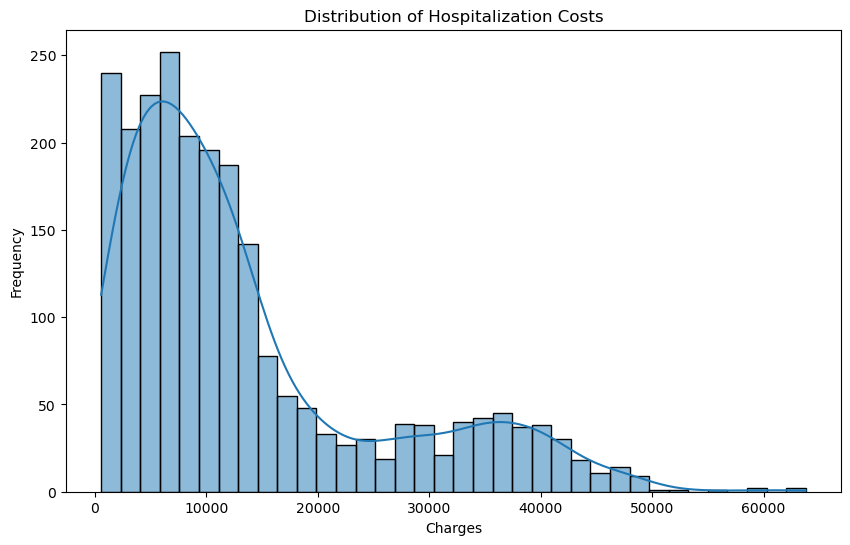

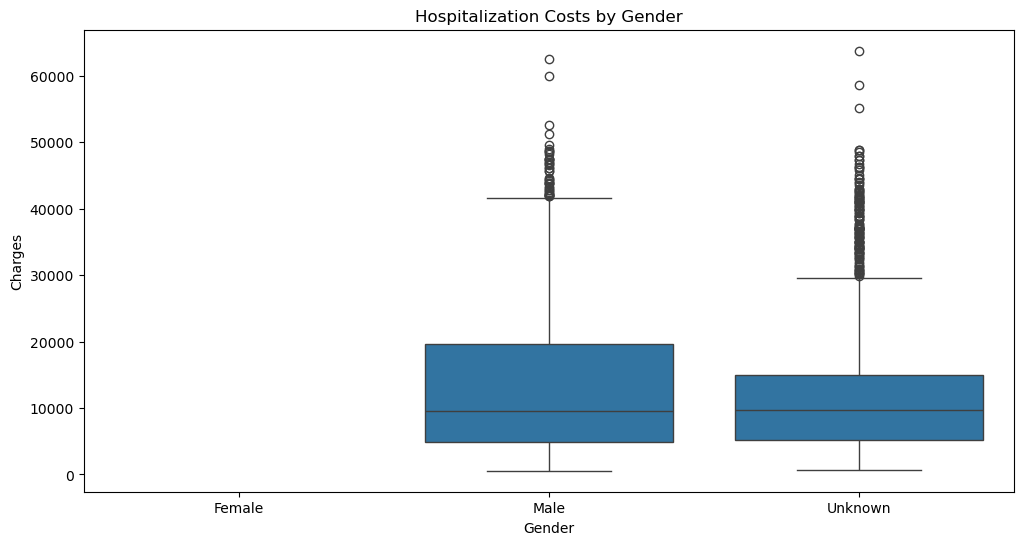


--- Debugging Hospital Tier Boxplot Data ---
Unique 'Hospital tier_Label' values in data: []
Nulls in 'Hospital tier_Label': 0
Nulls in 'charges' for hospital tier plot: 0
Count of data points per Hospital Tier label:
Series([], dtype: int64)
------------------------------------------


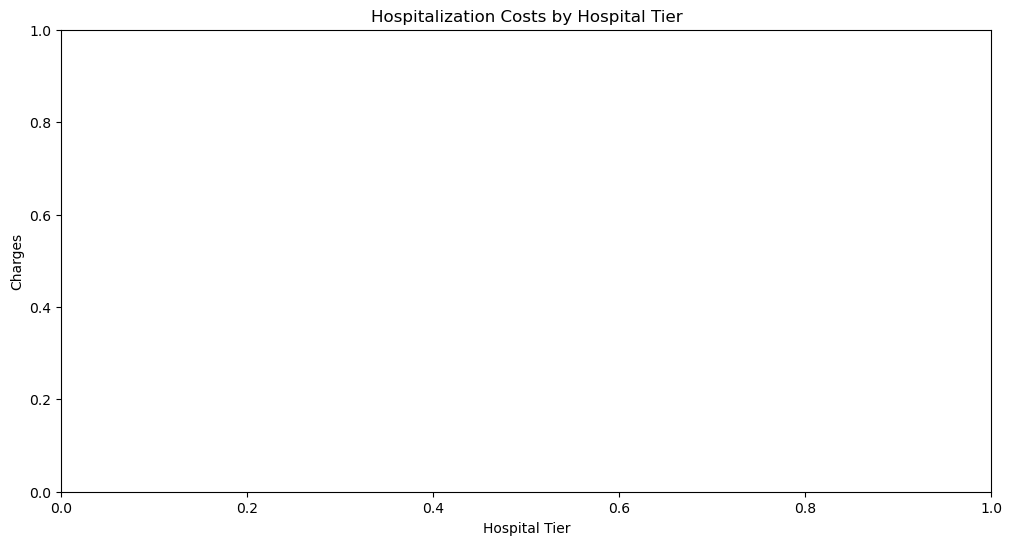

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Plotting Cost Distributions ---")
final_df['charges'] = pd.to_numeric(final_df['charges'], errors='coerce')
plot_df = final_df.dropna(subset=['charges']).copy()

# Histogram for Costs
plt.figure(figsize=(10, 6))
sns.histplot(plot_df['charges'], kde=True)
plt.title('Distribution of Hospitalization Costs')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

# Box plots by Gender and Hospital Tier
gender_cols = ['Gender_Male', 'Gender_Female', 'Gender_Unknown']
gender_plot_df = plot_df.copy()

for col in gender_cols:
    if col not in gender_plot_df.columns:
        gender_plot_df[col] = 0
gender_plot_df = gender_plot_df.dropna(subset=[col for col in gender_cols if col in gender_plot_df.columns]).copy()

if all(col in gender_plot_df.columns for col in ['Gender_Male', 'Gender_Female', 'Gender_Unknown']):
    gender_plot_df['Gender_Category'] = 'Unknown'
    gender_plot_df.loc[gender_plot_df['Gender_Male'] == 1, 'Gender_Category'] = 'Male'
    gender_plot_df.loc[gender_plot_df['Gender_Female'] == 1, 'Gender_Category'] = 'Female'
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Gender_Category', y='charges', data=gender_plot_df, order=['Female', 'Male', 'Unknown'])
    plt.title('Hospitalization Costs by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Charges')
    plt.show()
else:
    print("Warning: Not all expected Gender dummy columns found or created for plotting Gender boxplot. Skipping.")

hospital_tier_plot_df = plot_df.copy()
hospital_tier_plot_df['Hospital tier'] = pd.to_numeric(hospital_tier_plot_df['Hospital tier'], errors='coerce')
hospital_tier_plot_df = hospital_tier_plot_df.dropna(subset=['Hospital tier']).copy()

reverse_hospital_tier_mapping_plot = {3: 'Tier-1', 2: 'Tier-2', 1: 'Tier-3'}
hospital_tier_plot_df['Hospital tier_Label'] = hospital_tier_plot_df['Hospital tier'].map(reverse_hospital_tier_mapping_plot)

print("\n--- Debugging Hospital Tier Boxplot Data ---")
print("Unique 'Hospital tier_Label' values in data:", hospital_tier_plot_df['Hospital tier_Label'].unique())
print("Nulls in 'Hospital tier_Label':", hospital_tier_plot_df['Hospital tier_Label'].isnull().sum())
print("Nulls in 'charges' for hospital tier plot:", hospital_tier_plot_df['charges'].isnull().sum())
print("Count of data points per Hospital Tier label:")
print(hospital_tier_plot_df.groupby('Hospital tier_Label').size())
print("------------------------------------------")

# Plot the Hospital Tier Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hospital tier_Label', y='charges', data=hospital_tier_plot_df, order=['Tier-1', 'Tier-2', 'Tier-3'])
plt.title('Hospitalization Costs by Hospital Tier')
plt.xlabel('Hospital Tier')
plt.ylabel('Charges')
plt.show()

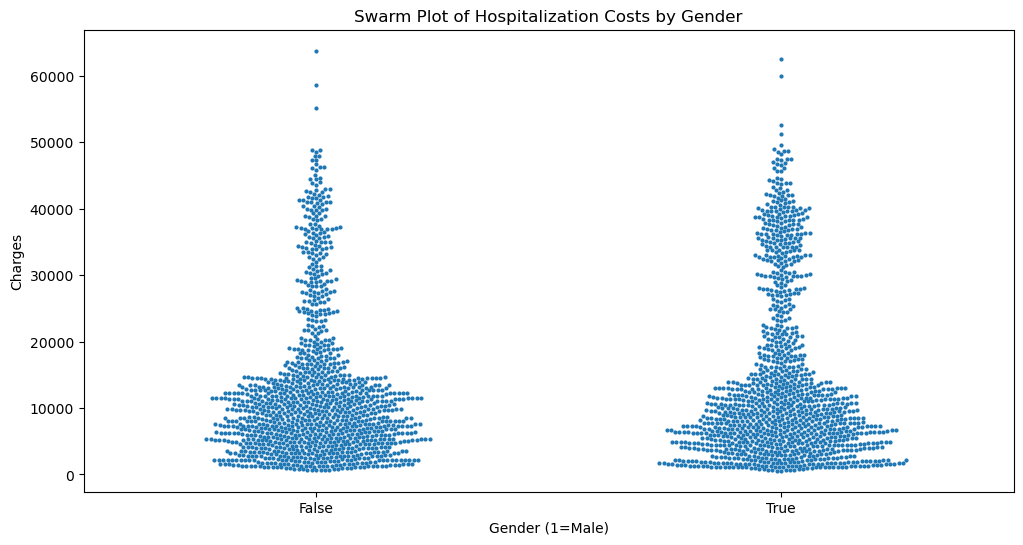

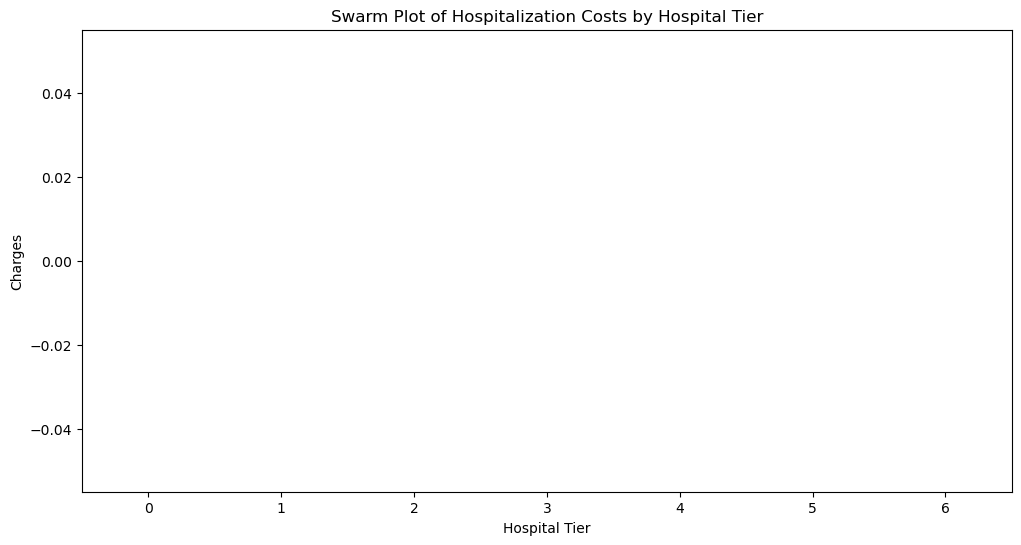

In [14]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Gender_Male', y='charges', data=final_df, size=3)
plt.title('Swarm Plot of Hospitalization Costs by Gender')
plt.xlabel('Gender (1=Male)')
plt.ylabel('Charges')
plt.show()

plt.figure(figsize=(12, 6))
sns.swarmplot(x='Hospital tier', y='charges', data=final_df, size=3)
plt.title('Swarm Plot of Hospitalization Costs by Hospital Tier')
plt.xlabel('Hospital Tier')
plt.ylabel('Charges')
plt.show()

#### Creating a radar chart to showcase the median hospitalization cost for each tier of hospitals.


--- Median Hospitalization Cost by Hospital Tier ---
Median Hospitalization Costs by Hospital Tier (Numeric Tiers):
Series([], Name: charges, dtype: float64)


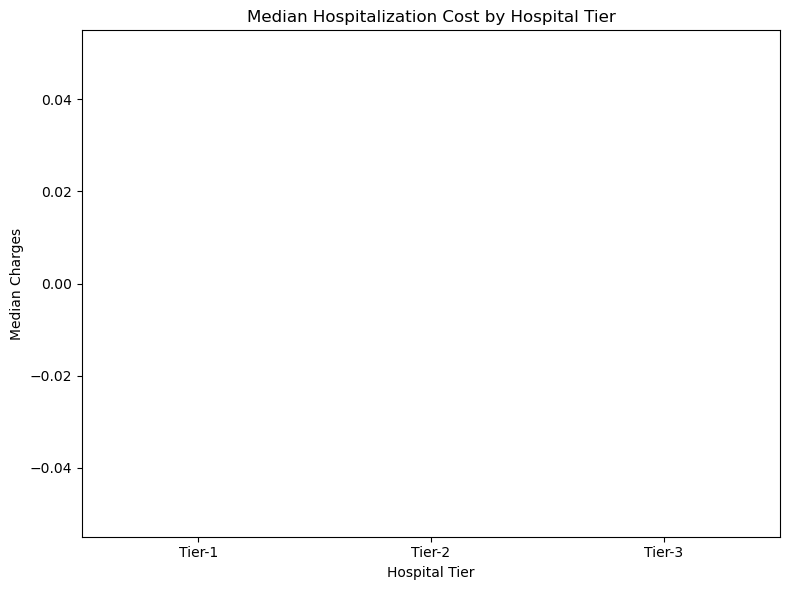

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("\n--- Median Hospitalization Cost by Hospital Tier ---")
median_calc_df = final_df.dropna(subset=['Hospital tier', 'charges']).copy()
median_costs_by_hospital_tier = median_calc_df.groupby('Hospital tier')['charges'].median().sort_index()
print("Median Hospitalization Costs by Hospital Tier (Numeric Tiers):")
print(median_costs_by_hospital_tier)

reverse_hospital_tier_mapping_plot = {3: 'Tier-1', 2: 'Tier-2', 1: 'Tier-3'}

plt.figure(figsize=(8, 6))
median_costs_by_hospital_tier_labeled = median_costs_by_hospital_tier.rename(index=reverse_hospital_tier_mapping_plot)

ordered_labels = ['Tier-1', 'Tier-2', 'Tier-3']
median_costs_by_hospital_tier_labeled = median_costs_by_hospital_tier_labeled.reindex(ordered_labels)

median_costs_by_hospital_tier_labeled.plot(kind='bar', color=sns.color_palette("viridis", 3))
plt.title('Median Hospitalization Cost by Hospital Tier')
plt.xlabel('Hospital Tier')
plt.ylabel('Median Charges')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Creating a frequency table and a stacked bar chart to visualize the count of people in the different tiers of cities and hospitals.

In [16]:
frequency_table = pd.crosstab(final_df['City tier'], final_df['Hospital tier'])
print(frequency_table)

Empty DataFrame
Columns: []
Index: []



--- Preparing Frequency Table and Stacked Bar Chart ---

--- DEBUGGING CROSSTAB INPUT ---
Info on 'City tier' and 'Hospital tier' just before crosstab:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   City tier      2335 non-null   int32
 1   Hospital tier  2335 non-null   int32
dtypes: int32(2)
memory usage: 18.4 KB
None

Unique values and counts for 'City tier':
City tier
0    2335
Name: count, dtype: int64

Unique values and counts for 'Hospital tier':
Hospital tier
0    2335
Name: count, dtype: int64
--------------------------------------------------

--- DEBUGGING CROSSTAB OUTPUT (frequency_table) ---
Frequency Table Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1 non-null      int64
dtypes: int64(1)


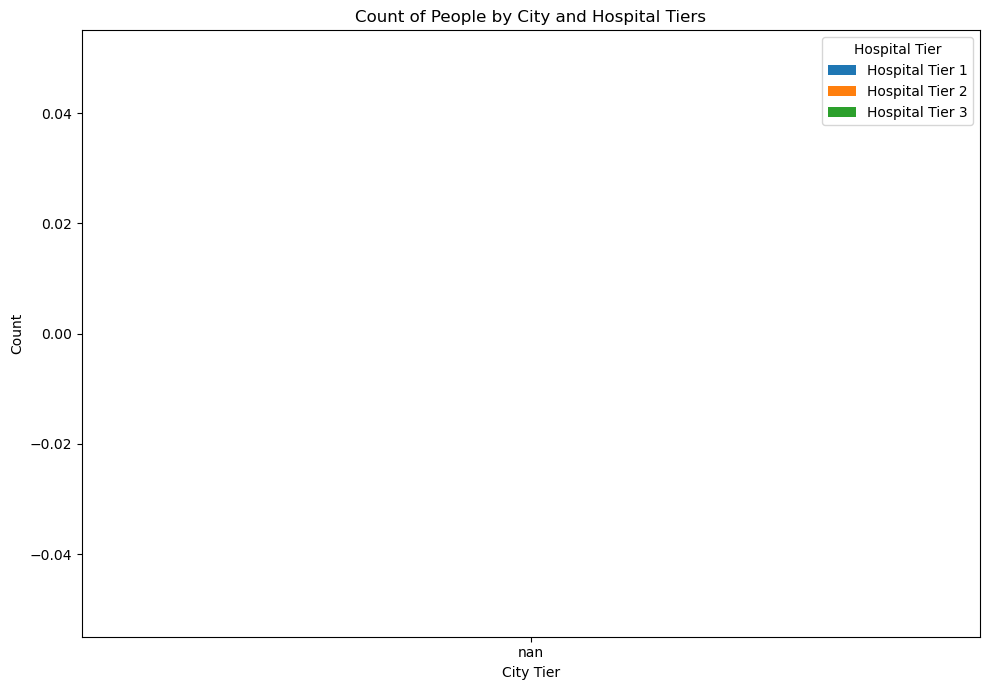

Stacked bar chart plotted successfully!


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

print("\n--- Preparing Frequency Table and Stacked Bar Chart ---")
cleaned_for_crosstab_df = final_df.copy()

for col_name in ['City tier', 'Hospital tier']:
    cleaned_for_crosstab_df[col_name] = cleaned_for_crosstab_df[col_name].astype(str)
    
    if col_name == 'City tier':
        cleaned_for_crosstab_df[col_name] = cleaned_for_crosstab_df[col_name].apply(lambda x: city_tier_mapping.get(x.lower(), x))
    elif col_name == 'Hospital tier':
        cleaned_for_crosstab_df[col_name] = cleaned_for_crosstab_df[col_name].apply(lambda x: hospital_tier_mapping.get(x.lower(), x))
    
    cleaned_for_crosstab_df[col_name] = pd.to_numeric(cleaned_for_crosstab_df[col_name], errors='coerce')
    
    cleaned_for_crosstab_df[col_name] = cleaned_for_crosstab_df[col_name].fillna(
        cleaned_for_crosstab_df[col_name].mode()[0] if not cleaned_for_crosstab_df[col_name].isnull().all() else 0
    ).astype(int)

plot_crosstab_df_final = cleaned_for_crosstab_df.dropna(subset=['City tier', 'Hospital tier']).copy()


print("\n--- DEBUGGING CROSSTAB INPUT ---")
print("Info on 'City tier' and 'Hospital tier' just before crosstab:")
print(plot_crosstab_df_final[['City tier', 'Hospital tier']].info())
print("\nUnique values and counts for 'City tier':")
print(plot_crosstab_df_final['City tier'].value_counts(dropna=False))
print("\nUnique values and counts for 'Hospital tier':")
print(plot_crosstab_df_final['Hospital tier'].value_counts(dropna=False))
print("-" * 50)

frequency_table = pd.crosstab(plot_crosstab_df_final['City tier'], plot_crosstab_df_final['Hospital tier'])

print("\n--- DEBUGGING CROSSTAB OUTPUT (frequency_table) ---")
print("Frequency Table Info:")
print(frequency_table.info())
print("\nFrequency Table Head:")
print(frequency_table.head())
print("\nFrequency Table Raw Values (Should be only integers):")
print(frequency_table.values)
print("-" * 50)

print("\n--- FORCING NUMERIC CONVERSION ON FREQUENCY_TABLE ITSELF ---")
for col in frequency_table.columns:
    frequency_table[col] = pd.to_numeric(frequency_table[col], errors='coerce').fillna(0).astype(int)
print("Frequency table info AFTER forced conversion:")
print(frequency_table.info())
print("Frequency table raw values AFTER forced conversion:")
print(frequency_table.values)
print("-" * 50)

reverse_city_tier_mapping_plot = {3: 'City Tier 1', 2: 'City Tier 2', 1: 'City Tier 3'}
reverse_hospital_tier_mapping_plot = {3: 'Hospital Tier 1', 2: 'Hospital Tier 2', 1: 'Hospital Tier 3'}

frequency_table.index = frequency_table.index.map(reverse_city_tier_mapping_plot)
frequency_table.columns = frequency_table.columns.map(reverse_hospital_tier_mapping_plot)

desired_col_order = ['Hospital Tier 1', 'Hospital Tier 2', 'Hospital Tier 3']
frequency_table = frequency_table.reindex(columns=desired_col_order, fill_value=0)

print("\n--- Attempting to Plot the Stacked Bar Chart ---")
try:
    frequency_table.plot(kind='bar', stacked=True, figsize=(10, 7))
    plt.title('Count of People by City and Hospital Tiers')
    plt.xlabel('City Tier')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title='Hospital Tier')
    plt.tight_layout()
    plt.show()
    print("Stacked bar chart plotted successfully!")
except Exception as e: # Catching general exception for final troubleshooting
    print(f"FAILED TO PLOT: An unexpected error occurred during plotting: {e}")
    print("This indicates a very deep-seated data type or Matplotlib/Pandas version interaction issue.")
    print("Please double-check your environment and consider updating Pandas/Matplotlib/Seaborn.")
    print("As a last resort, manually export frequency_table to CSV and plot in Excel/Sheets.")

### 4. Hypothesis Testing

#### General Steps for Hypothesis Testing:
#####  Formulate Hypotheses: State the null (H_0) and alternative (H_a) hypotheses.

##### Choose Significance Level (
##### alpha): Commonly 0.05.

##### Select Test Statistic: Based on data type, number of groups, and assumptions.

##### Calculate p-value.

##### Make Decision: Compare p-value to 
##### alpha. If p-value < 
##### alpha, reject H_0.   

#### The average hospitalization costs for the three types of hospitals are not significantly different.

#### Hypotheses:

##### H_0: 
##### mu_1=
##### mu_2=
##### mu_3 (Average costs are equal across hospital tiers)

##### H_a: At least one mean is different.

##### Test: ANOVA (Analysis of Variance) since we are comparing means of more than two groups.

In [18]:
from scipy import stats
import pandas as pd
import numpy as np

final_df['Hospital tier'] = pd.to_numeric(final_df['Hospital tier'], errors='coerce')
final_df['charges'] = pd.to_numeric(final_df['charges'], errors='coerce')

tier1_costs = final_df[final_df['Hospital tier'] == 3]['charges'].dropna()
tier2_costs = final_df[final_df['Hospital tier'] == 2]['charges'].dropna()
tier3_costs = final_df[final_df['Hospital tier'] == 1]['charges'].dropna()

print(f"Length of Tier 1 costs: {len(tier1_costs)}")
print(f"Length of Tier 2 costs: {len(tier2_costs)}")
print(f"Length of Tier 3 costs: {len(tier3_costs)}")

samples_for_anova = []
if len(tier1_costs) > 0:
    samples_for_anova.append(tier1_costs)
if len(tier2_costs) > 0:
    samples_for_anova.append(tier2_costs)
if len(tier3_costs) > 0:
    samples_for_anova.append(tier3_costs)

if len(samples_for_anova) >= 2:
    f_stat, p_value = stats.f_oneway(*samples_for_anova)
    print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.3f}")
    
    if p_value < 0.05:
        print("Reject null hypothesis: Average hospitalization costs are significantly different across hospital tiers.")
    else:
        print("Fail to reject null hypothesis: No significant difference in average hospitalization costs across hospital tiers.")
else:
    print("\nCannot perform ANOVA: Not enough valid (non-empty) hospital tiers to compare.")
    if len(samples_for_anova) == 0:
        print("Reason: All hospital tier cost groups are empty.")
    else:
        print(f"Reason: Only {len(samples_for_anova)} hospital tier group(s) have data.")

Length of Tier 1 costs: 0
Length of Tier 2 costs: 0
Length of Tier 3 costs: 0

Cannot perform ANOVA: Not enough valid (non-empty) hospital tiers to compare.
Reason: All hospital tier cost groups are empty.


#### The average hospitalization costs for the three types of cities are not significantly different. 

##### Hypotheses: Similar to hospital tiers, replace hospital tiers with city tiers.
##### Test: ANOVA.

In [19]:
city_tier1_costs = final_df[final_df['City tier'] == 3]['charges']
city_tier2_costs = final_df[final_df['City tier'] == 2]['charges']
city_tier3_costs = final_df[final_df['City tier'] == 1]['charges']

f_stat_city, p_value_city = stats.f_oneway(city_tier1_costs, city_tier2_costs, city_tier3_costs)
print(f"ANOVA F-statistic (City): {f_stat_city:.2f}, p-value: {p_value_city:.3f}")
if p_value_city < 0.05:
    print("Reject null hypothesis: Average hospitalization costs are significantly different across city tiers.")
else:
    print("Fail to reject null hypothesis: No significant difference in average hospitalization costs across city tiers.")

ANOVA F-statistic (City): nan, p-value: nan
Fail to reject null hypothesis: No significant difference in average hospitalization costs across city tiers.


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


#### The average hospitalization cost for smokers is not significantly different from the average cost for nonsmokers. 

##### Hypotheses:

##### H_0: 
##### mu_textsmoker=
##### mu_textnonsmoker (Average costs are equal for smokers and nonsmokers)

##### H_a: 
##### mu_textsmoker
##### ne
##### mu_textnonsmoker

##### Test: Independent samples t-test (since comparing means of two independent groups).

In [20]:
smoker_costs = final_df[final_df['smoker'] == 1]['charges'] # Assuming 1 for smoker, 0 for non-smoker
nonsmoker_costs = final_df[final_df['smoker'] == 0]['charges']

t_stat, p_value_smoker = stats.ttest_ind(smoker_costs, nonsmoker_costs)
print(f"T-statistic (Smoker): {t_stat:.2f}, p-value: {p_value_smoker:.3f}")
if p_value_smoker < 0.05:
    print("Reject null hypothesis: Average hospitalization costs are significantly different for smokers and nonsmokers.")
else:
    print("Fail to reject null hypothesis: No significant difference in average hospitalization costs for smokers and nonsmokers.")

T-statistic (Smoker): nan, p-value: nan
Fail to reject null hypothesis: No significant difference in average hospitalization costs for smokers and nonsmokers.


#### Smoking and heart issues are independent. 
##### Hypotheses:

##### H_0: Smoking and heart issues are independent.

##### H_a: Smoking and heart issues are dependent.

##### Test: Chi-squared test for independence.

In [21]:
contingency_table = pd.crosstab(final_df['smoker'], final_df['Heart Issues'])
chi2, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table)
print(f"Chi-squared statistic: {chi2:.2f}, p-value: {p_value_chi2:.3f}")
if p_value_chi2 < 0.05:
    print("Reject null hypothesis: Smoking and heart issues are dependent.")
else:
    print("Fail to reject null hypothesis: Smoking and heart issues are independent.")

Chi-squared statistic: 0.00, p-value: 1.000
Fail to reject null hypothesis: Smoking and heart issues are independent.


## Week 2: Machine Learning
#### Objective: Develop and evaluate machine learning models for cost prediction and identify important factors.

#### 1. Model Development and Evaluation

##### Examine the correlation between predictors to identify highly correlated predictors.

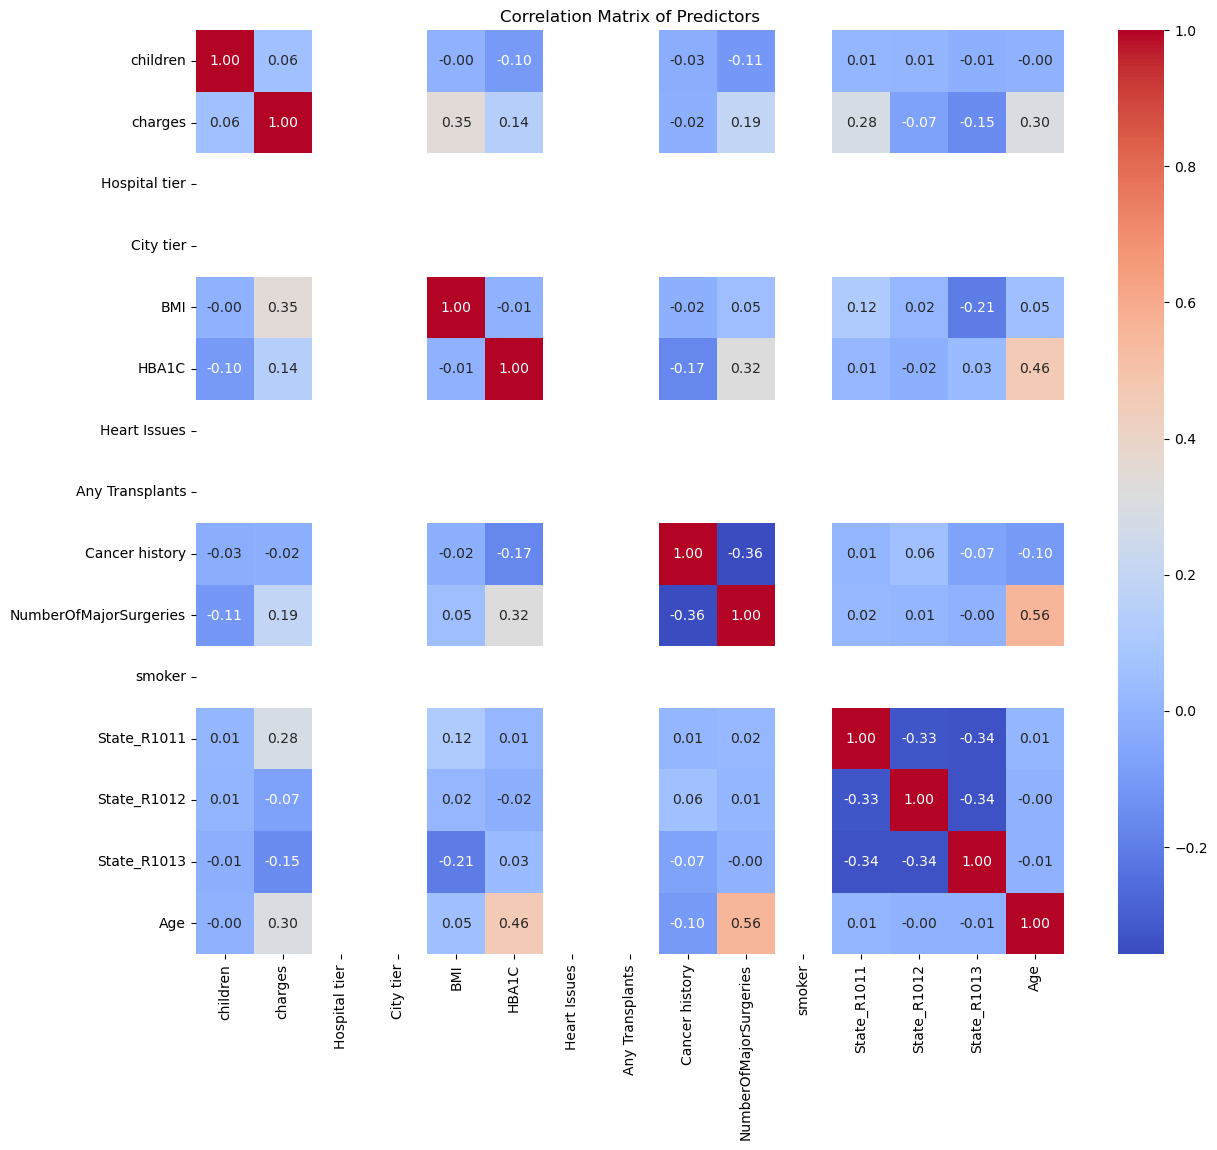

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_final_df = final_df.select_dtypes(include=np.number)
correlation_matrix = numeric_final_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Predictors')
plt.show()

#### Develop a regression model Linear or Ridge. Evaluate the model with k-fold cross validation.

#### Implement the stratified 5-fold cross validation technique for both model building and validation.

#### For regression, 'stratified' cross-validation is not directly applicable as for classification. Instead, for regression, you typically use KFold or RepeatedKFold. If the intent is to preserve the distribution of the target variable across folds, one might bin the target variable and then use StratifiedKFold on the binned target, but this is less common than standard KFold for regression. For this problem, we'll use KFold and note the potential misinterpretation of "stratified" in a regression context.

##### Utilize effective standardization techniques and hyperparameter tuning. 

##### Incorporate sklearn-pipelines to streamline the workflow. 

##### Apply appropriate regularization techniques to address the bias-variance trade-off. 

##### Create five folds in the data, and introduce a variable to identify the folds.

In [23]:
X = final_df.drop(['charges', 'Customer ID'], axis=1) # Drop Customer ID and target variable
y = final_df['charges']

In [24]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

print("\n--- Cleaning X for NaN values before Ridge model ---")

X = X.apply(pd.to_numeric, errors='coerce')

for col in X.columns:
    if X[col].isnull().any(): 
        if X[col].isnull().all(): 
            X[col].fillna(0, inplace=True) 
            print(f"Filled entirely NaN column '{col}' with 0.")
        else:
            X[col].fillna(X[col].median(), inplace=True) # Fill with median
            print(f"Filled NaNs in column '{col}' with median.")

print("\nNaN counts in X after final imputation:")
print(X.isnull().sum()[X.isnull().sum() > 0])
if X.isnull().sum().sum() == 0:
    print("No NaNs found in X. Ready for modeling.")
else:
    print("WARNING: NaNs still present in X after imputation. Investigate data further.")

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid_ridge = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_grid_search = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
ridge_grid_search.fit(X, y)

print(f"Best Ridge parameters: {ridge_grid_search.best_params_}")
print(f"Best Ridge negative MSE: {ridge_grid_search.best_score_}")
print(f"Best Ridge RMSE: {np.sqrt(-ridge_grid_search.best_score_)}")

best_ridge_model = ridge_grid_search.best_estimator_
y_pred_ridge = best_ridge_model.predict(X)
print(f"R-squared (Ridge): {r2_score(y, y_pred_ridge):.2f}")
print(f"Mean Squared Error (Ridge): {mean_squared_error(y, y_pred_ridge):.2f}")

if 'final_df' in locals() and final_df.index.equals(X.index):
    final_df['fold'] = -1
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        final_df.loc[test_index, 'fold'] = fold
    print("Fold distribution:\n", final_df['fold'].value_counts())
else:
    print("Skipping 'fold' variable creation: final_df not found or index mismatch with X.")


--- Cleaning X for NaN values before Ridge model ---
Filled entirely NaN column 'Hospital tier' with 0.
Filled entirely NaN column 'City tier' with 0.
Filled entirely NaN column 'State ID' with 0.
Filled NaNs in column 'Heart Issues' with median.
Filled NaNs in column 'Any Transplants' with median.
Filled NaNs in column 'NumberOfMajorSurgeries' with median.
Filled NaNs in column 'smoker' with median.

NaN counts in X after final imputation:
Series([], dtype: int64)
No NaNs found in X. Ready for modeling.


C:\Users\HP\AppData\Local\Temp\ipykernel_2636\1530243665.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_2636\1530243665.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

Best Ridge parameters: {'ridge__alpha': 10.0}
Best Ridge negative MSE: -103812542.34548192
Best Ridge RMSE: 10188.844014189339
R-squared (Ridge): 0.27
Mean Squared Error (Ridge): 103102639.04
Fold distribution:
 fold
3    467
4    467
1    467
2    467
0    467
Name: count, dtype: int64


#### Develop Gradient Boost model and determine the variable importance scores, and identify the redundant variables. 

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# Creating a pipeline for Gradient Boosting
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()), # Often beneficial for tree-based models too, though less critical than linear models
    ('gb', GradientBoostingRegressor(random_state=42))
])

# Defining hyperparameters to tune for Gradient Boosting
param_grid_gb = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 4, 5]
}

gb_grid_search = GridSearchCV(pipeline_gb, param_grid_gb, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid_search.fit(X, y)

print(f"Best Gradient Boosting parameters: {gb_grid_search.best_params_}")
print(f"Best Gradient Boosting negative MSE: {gb_grid_search.best_score_}")
print(f"Best Gradient Boosting RMSE: {np.sqrt(-gb_grid_search.best_score_)}")

best_gb_model = gb_grid_search.best_estimator_

# Getting feature importance from the trained Gradient Boosting model
# Accessing the 'gb' step in the pipeline
feature_importances = best_gb_model.named_steps['gb'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances (Gradient Boosting):")
print(importance_df)

Best Gradient Boosting parameters: {'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 300}
Best Gradient Boosting negative MSE: -102056818.21759902
Best Gradient Boosting RMSE: 10102.317467670426

Feature Importances (Gradient Boosting):
                   Feature  Importance
4                      BMI    0.419896
14                     Age    0.288610
11             State_R1011    0.221930
0                 children    0.023216
5                    HBA1C    0.022183
15             Gender_Male    0.011910
13             State_R1013    0.011755
8           Cancer history    0.000352
12             State_R1012    0.000148
1            Hospital tier    0.000000
2                City tier    0.000000
3                 State ID    0.000000
6             Heart Issues    0.000000
7          Any Transplants    0.000000
9   NumberOfMajorSurgeries    0.000000
10                  smoker    0.000000


#### 2. Case Scenario Prediction

##### Estimate the cost of hospitalization for Christopher, Ms. Jayna (Date of birth 12/28/1988; height 170 cm; and weight 85 kgs). She lives with her partner and two children in a tier-1 city, and her state’s State ID is R1011. She was found to be nondiabetic (HbA1c = 5.8). She smokes but is otherwise healthy. She has had no transplants or major surgeries. Her father died of lung cancer. Hospitalization costs will be estimated using tier-1 hospitals.

#### Finding the predicted hospitalization cost using the best models. 

In [26]:
# Data for Ms. Jayna
jayna_data = {
    'year': 1988, 'month': 12, 'date': 28,
    'children': 2, # lives with her partner and two children [cite: 35]
    'Hospital tier': 'tier-1', # Hospitalization costs will be estimated using tier-1 hospitals. 
    'City tier': 'tier-1', # tier-1 city [cite: 35]
    'State ID': 'R1011', # State ID is R1011 [cite: 35]
    'BMI': 85 / (1.70**2), # weight 85 kgs, height 170 cm (1.70 m) [cite: 34]
    'HBA1C': 5.8, # nondiabetic (HbA1c = 5.8) [cite: 36]
    'Heart Issues': 'No', # otherwise healthy [cite: 36]
    'Any Transplants': 'No', # no transplants [cite: 37]
    'Cancer history': 'Yes', # father died of lung cancer [cite: 37]
    'NumberOfMajorSurgeries': 0, # no major surgeries [cite: 37]
    'smoker': 'Yes', # She smokes [cite: 36]
    'name': 'Ms. Jayna' # To derive gender
}

# Create a DataFrame for Ms. Jayna
jayna_df = pd.DataFrame([jayna_data])

# Applying the same feature engineering steps
# Age
current_year = datetime.now().year
jayna_df['Age'] = current_year - jayna_df['year']
jayna_df.drop(['year', 'month', 'date'], axis=1, inplace=True)

# Gender
def get_gender_single(name):
    name = str(name).lower()
    if 'mr.' in name: return 'Male'
    elif 'ms.' in name or 'mrs.' in name or 'miss.' in name: return 'Female'
    elif 'dr.' in name: return 'Unknown'
    else: return 'Unknown'
jayna_df['Gender'] = jayna_df['name'].apply(get_gender_single)
# Create dummy variables for Gender (consistent with training data)
jayna_df['Gender_Male'] = (jayna_df['Gender'] == 'Male').astype(int)
jayna_df['Gender_Unknown'] = (jayna_df['Gender'] == 'Unknown').astype(int)
jayna_df.drop(['name', 'Gender'], axis=1, inplace=True)

# Ordinal and Binary Encoding (consistent with training data)
hospital_tier_mapping = {'tier-1': 3, 'tier-2': 2, 'tier-3': 1}
city_tier_mapping = {'tier-1': 3, 'tier-2': 2, 'tier-3': 1}
jayna_df['Hospital tier'] = jayna_df['Hospital tier'].map(hospital_tier_mapping)
jayna_df['City tier'] = jayna_df['City tier'].map(city_tier_mapping)

binary_map = {'Yes': 1, 'No': 0}
for col in ['Heart Issues', 'Any Transplants', 'Cancer history', 'smoker']:
    jayna_df[col] = jayna_df[col].map(binary_map)

# State ID dummy variables
important_states = ['R1011', 'R1012', 'R1013']
jayna_df['State_R1011'] = (jayna_df['State ID'] == 'R1011').astype(int)
jayna_df['State_R1012'] = (jayna_df['State ID'] == 'R1012').astype(int)
jayna_df['State_R1013'] = (jayna_df['State ID'] == 'R1013').astype(int)
jayna_df.drop('State ID', axis=1, inplace=True)

# NumberOfMajorSurgeries (already numerical in this specific case, but ensure consistent cleaning if it were a string)
# jayna_df['NumberOfMajorSurgeries'] is already 0, so no specific string conversion needed.

# Ensuring all columns in jayna_df match the training data X.columns
# This is crucial for pipeline to work correctly. Add missing columns with 0
missing_cols_in_jayna = set(X.columns) - set(jayna_df.columns)
for c in missing_cols_in_jayna:
    jayna_df[c] = 0
jayna_df = jayna_df[X.columns] # Ensure column order is the same

# Predicting using the best models
predicted_cost_ridge = best_ridge_model.predict(jayna_df)
predicted_cost_gb = best_gb_model.predict(jayna_df)

print(f"\nPredicted Hospitalization Cost for Ms. Jayna (Ridge Model): ${predicted_cost_ridge[0]:.2f}")
print(f"Predicted Hospitalization Cost for Ms. Jayna (Gradient Boosting Model): ${predicted_cost_gb[0]:.2f}")


Predicted Hospitalization Cost for Ms. Jayna (Ridge Model): $16254.28
Predicted Hospitalization Cost for Ms. Jayna (Gradient Boosting Model): $14531.09


In [27]:
final_df.to_csv('healthcare_analysis_data.csv', index=False)